# Imports and Utils

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from pathlib import Path
import joblib
from typing import Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rc('figure', figsize=(12,8))
plt.rc('lines', markersize=4)
plt.rc('font', size=30)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=20)
plt.rcParams["figure.autolayout"] = True

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import GridSearchCV

In [5]:
path = Path('model.pkl')

In [2]:
# CODE SOURCE IS DIRECTLY FROM DOCUMENTATION
# https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

def plot_svm_boundary(model,X,y):
    
    X = X.values
    y = y.values
    
    # Scatter Plot
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30,cmap='seismic')

    
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.show()

In [3]:
def model_summary(model:BaseEstimator) -> Union[list,pd.DataFrame,str,None]:
    """Calculates a summary of a classification model.  
    
    Args:
        model (BaseEstimator): Model can be any instance of sklearn models. Works best with SVM instances and alike.

    Returns:
        list[pd.DataFrame]: a list of two dataframes. The first one containing class info and other model more technical model info.
    """
    if not isinstance(model, BaseEstimator):
        return f'Model: {model=} is not a BaseEstimator instance.'
    try:
        check_is_fitted(model) #returns none if model is fitted
    except Exception as e:
        print(f'{e=}')
    else:
        
        df_class: pd.DataFrame = pd.DataFrame.from_dict(
            dict(
                classes = model.classes_,
                class_weight = model.class_weight_,
                n_support = model.n_support_
            )
        ).set_index('classes').T
        
        df_model: pd.DataFrame = pd.DataFrame.from_dict(
                    dict(
                        fit_status=model.fit_status_,
                        intercept=model.intercept_,
                        iterations=model.n_iter_,
                        shape_X = str(model.shape_fit_),
                        total_support_vectors = len(model.support_)
                    )
                ).T.rename({0:''}, axis=1)
        
        return [df_class, df_model]

# Data

Load data from creditcard.csv, the file can be downloaded in https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [14]:
df = pd.read_csv("creditcard.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Check for null or nan values

In [5]:
df.isnull().values.any()
df.isna().values.any()

False

False

Probe the class feature, which denotes fraud by 1 and normal transactions by 0

<AxesSubplot:xlabel='Class', ylabel='count'>

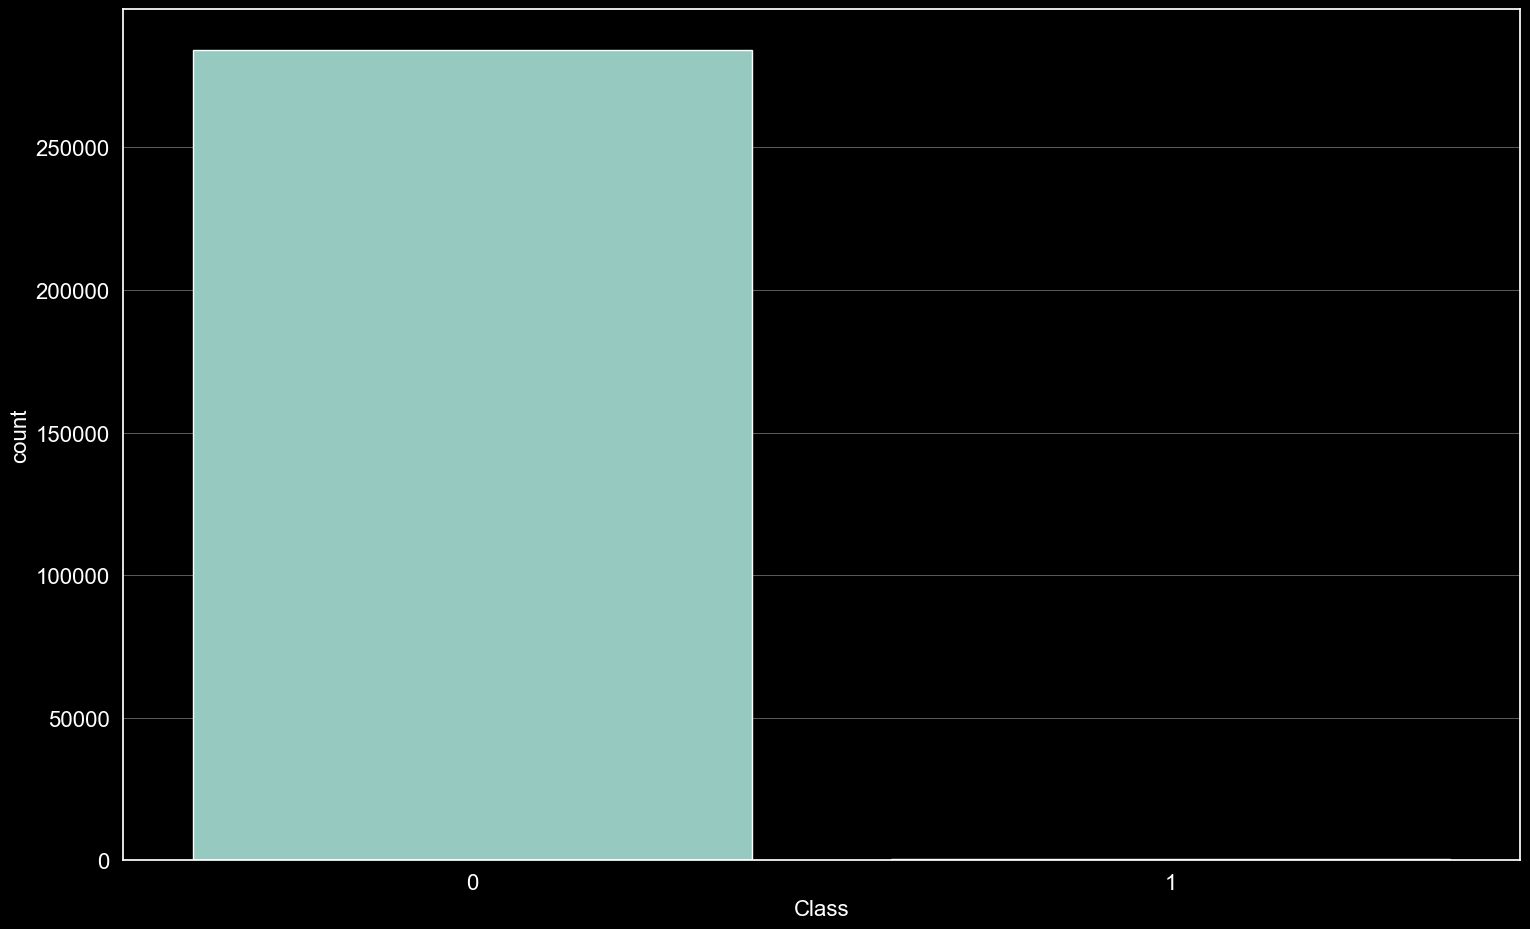

In [17]:
sns.countplot(data=df, x='Class')

In [15]:
df.loc[:, 'Class'].value_counts()
f'Fradulent transactions are {round(df.loc[:, "Class"].value_counts()[1]*100/len(df),2)}% of the total dataset'

0    284315
1       492
Name: Class, dtype: int64

'Fradulent transactions are 0.17% of the total dataset'

This is clearly a heavily inbalanced biclassification problem.

Let us check if there is any correlation between the ammount and the actual fraudulent cases

In [21]:
df.loc[:,('Amount', 'Class')].corr()

,Amount,Class
Amount,1.000000,0.005632
Class,0.005632,1.000000


Surprisingly there is none.

# Data Preparation

We define as y the Class columns and all the rest features are packed in X

In [15]:
X = df.drop('Class', axis=1)
y = df.loc[:,'Class']

We then perform a train and split with 10% test data.
- This is obviously not gonna work due to the heavy class inbalance but we will adress this after the evaluation.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

We scale further data by removing its mean and setting the deviation to 1.

In [17]:
scaler = StandardScaler()

In [18]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

# Model Train and Fit

We define the model by using class_weight=balance in order to fix the inbalance of the classes

In [13]:
model = SVC(class_weight='balanced')

We train the model

In [14]:
model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced')

Save the model since training took ~5mins

In [16]:
path.parent.mkdir(parents=True, exist_ok=True)
with path.open("wb") as outp:  # Overwrites any existing file.
    joblib.dump(model, outp)

# Model Inspection

Load the model

In [6]:
model = joblib.load(path)

Calculate model attributes in a dataframe format

In [7]:
model_summary_ = model_summary(model)

Inspect the weight assignment of the classes after fitting

In [8]:
model_summary_[0]

classes,0,1
class_weight,0.500864,289.961538
n_support,6403.000000,308.000000


Inspect other technical attributes

In [9]:
model_summary_[1]

,
fit_status,0
intercept,-0.901183
iterations,10425
shape_X,"(256326, 30)"
total_support_vectors,6711


- fit_status is an internal check of scikit that the fitting was performed correctly if the value is 0 (it is in our case)
- intercept is the constant in the decision function.

In [11]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Model Evaluation

First we calculate the predicted values


In [19]:
y_pred = model.predict(X_test_scaled)

Confusion matrix

In [22]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[28349,    82],
       [    8,    42]], dtype=int64)

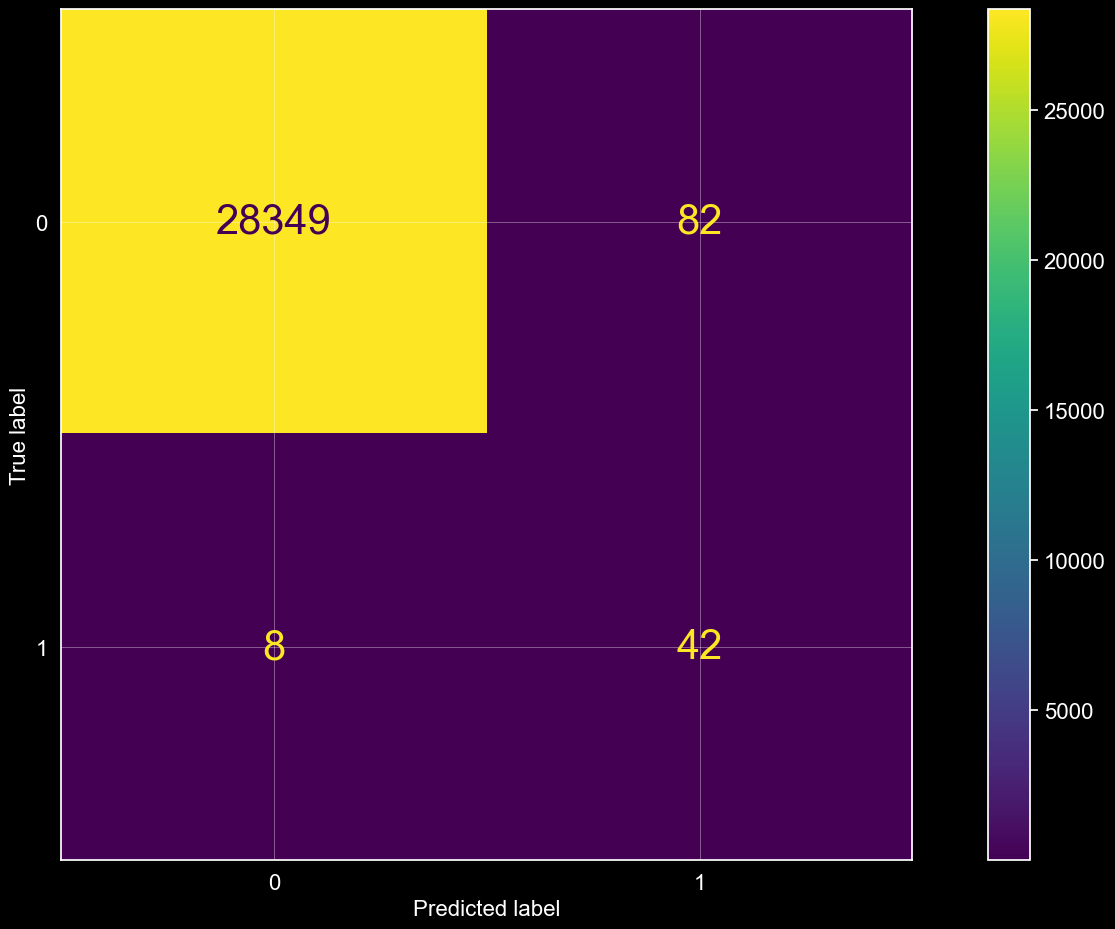

In [25]:
plt.rc('font', size=30)
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)

The off-diagonal elements are the one that got mis-classified

In [32]:
off_diag_sum = np.sum(conf_mat) - np.trace(conf_mat)
off_diag_sum

90

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28431
           1       0.34      0.84      0.48        50

    accuracy                           1.00     28481
   macro avg       0.67      0.92      0.74     28481
weighted avg       1.00      1.00      1.00     28481



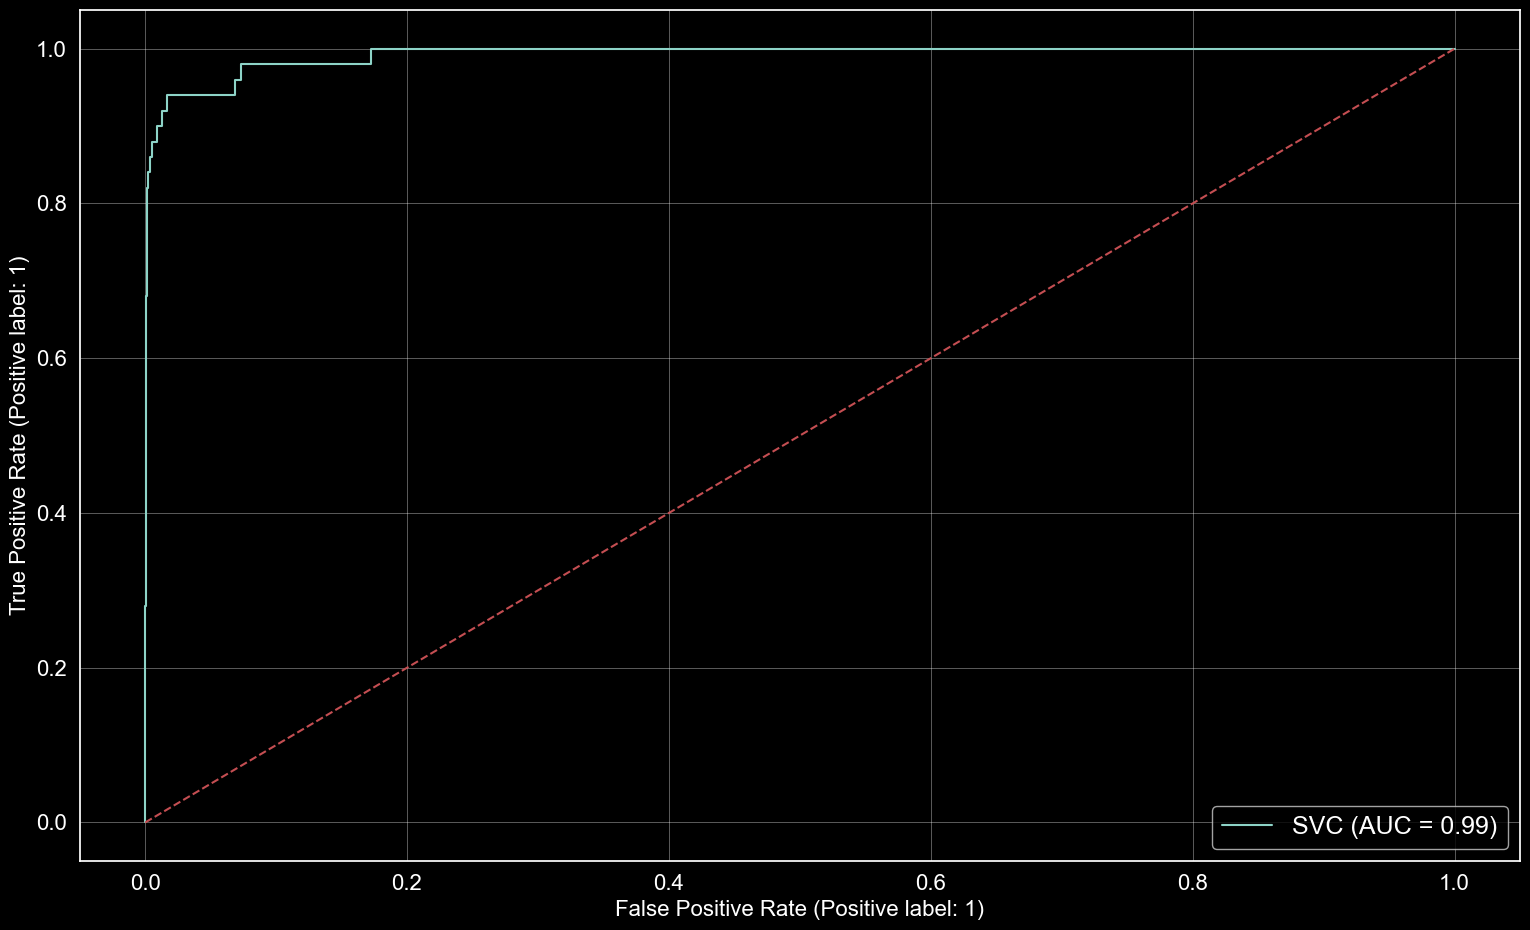

In [28]:
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.plot([0,1], [0,1], '--r', label='y=x, random classification')

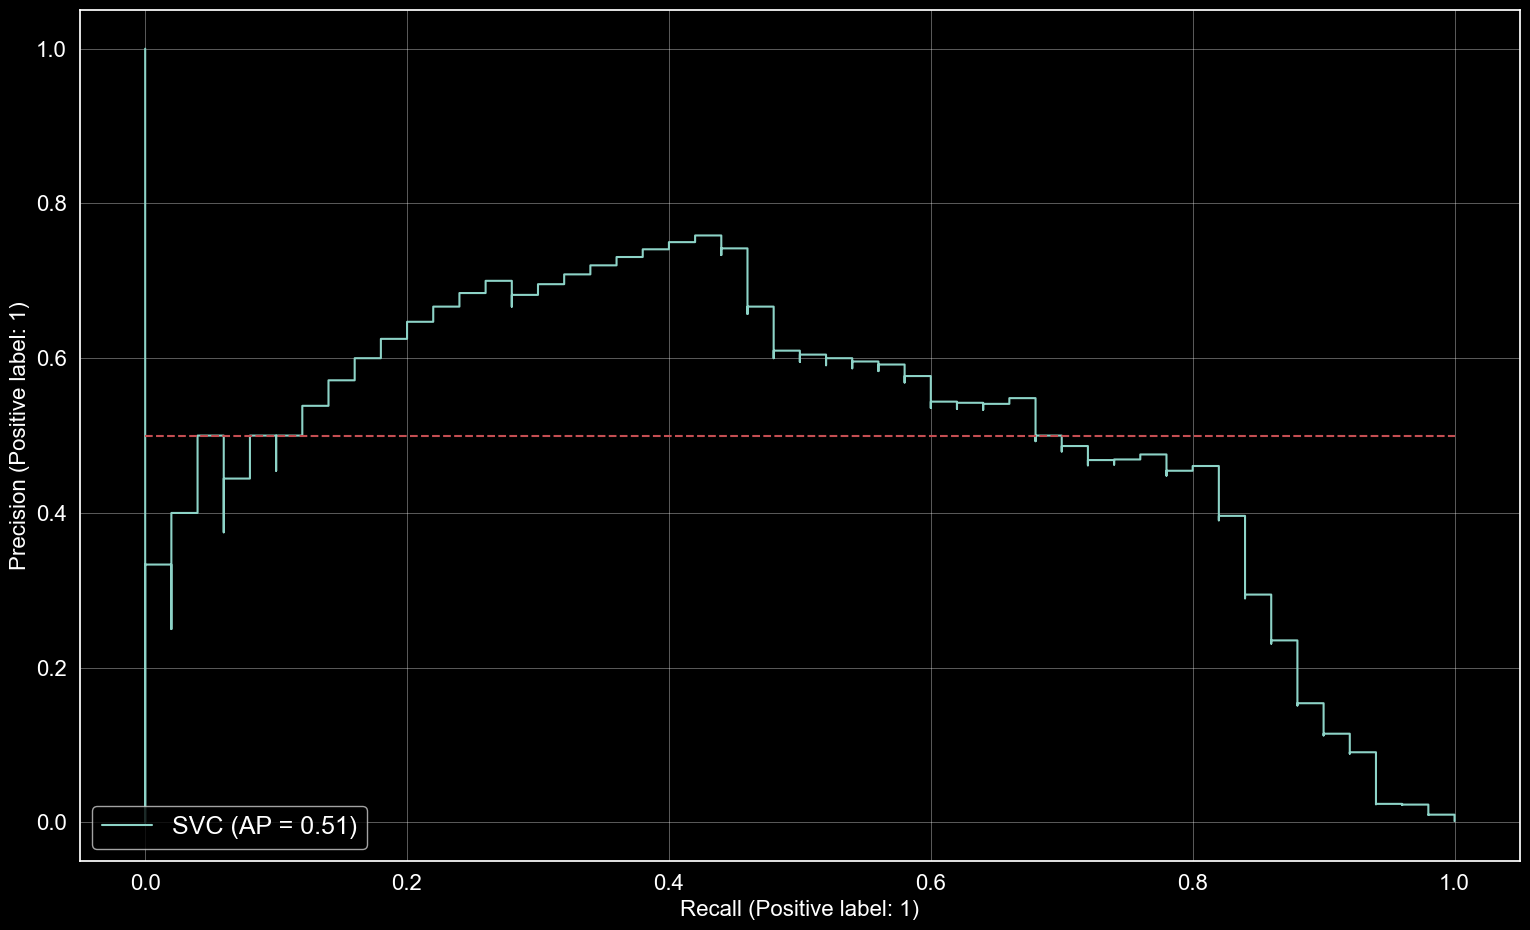

In [31]:
PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
plt.plot([0,1], [0.5,0.5], '--r', label='y=0.5, random classification')

As we have already seen due to the classes being inbalanced the precision, recall and f1 score are quite low.

The inbalance is really visible in the Precision-Recall plot where the area under the curve is 0.5, which is extremely low.

We will try to apply some resampling techniques in order to properly apply the SVM algorithm.